In [62]:
# Import ML and Preprocessing libraries
import cv2
import numpy as np
import os
import datetime
from skimage import io
import os
import random
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split

# 1. Preprocessing Data

In [63]:
# Import Gesture Classes with their respected labeled folders
dataset = glob.glob('data/*')


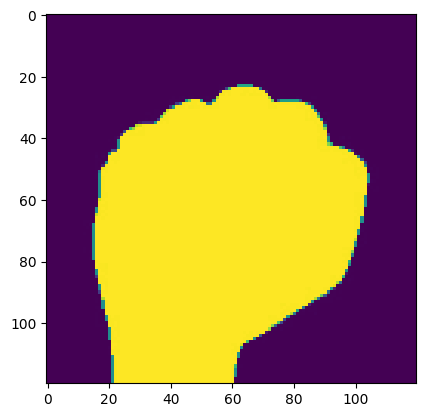

In [64]:
# Define a list of gesture names
gesture_list = ['blank', 'ok', 'thumbsup', 'thumbsdown', 'fist', 'five']

# Initialize a list to hold loaded images for each class
loaded_images = []

# Initialize the output vectors list
output_vectors = []

# Iterate through each gesture in the gesture list
for gesture_index, gesture in enumerate(gesture_list):
    # Construct the path to the dataset for the current gesture
    gesture_dataset_path = os.path.join("data", gesture)
    # Construct the path to the image files for the current gesture
    gesture_image_path = os.path.join(gesture_dataset_path, '*')
    # Get a list of all image file paths for the current gesture
    gesture_image_file_paths = glob.glob(gesture_image_path)

    # Iterate through each image file path
    for image_file_path in gesture_image_file_paths:
        # Read the image file
        image = cv2.imread(image_file_path)
        # Convert the image to grayscale
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Resize the image
        resized_image = cv2.resize(grayscale_image, (120, 120))
        # Append the processed image to the list of loaded images
        loaded_images.append(resized_image)
        # Append the corresponding output vector to the output vectors list
        output_vectors.append(gesture_index)

# Convert the list of loaded images to a numpy array
loaded_images_array = np.array(loaded_images)

# Convert gesture indices to one-hot encoded vectors
output_vectors_array = to_categorical(output_vectors, num_classes=len(gesture_list))

# Show sample image
first_image = loaded_images_array[8000]
plt.imshow(first_image)
plt.show()

In [65]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = X_train, X_test, y_train, y_test = train_test_split(loaded_images_array, output_vectors_array, test_size=0.2, random_state=21)
X_train = X_train.reshape(X_train.shape[0], 120, 120, 1)
X_test = X_test.reshape(X_test.shape[0], 120, 120, 1)


# Define Model

In [70]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Activation, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

# input shape
input_shape = (120, 120, 1)

# number of classes
num_classes = 6

# model
model = Sequential()

# first conv layer
model.add(Conv2D(64, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape)) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# second conv layer
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# third conv layer
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(256, activation='relu')) # fully connected
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(num_classes, activation='softmax'))

# model summary
optimiser = Adam() 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                            verbose=1, 
                                            min_lr=0.001)

# data augmentation
datagen = ImageDataGenerator(
        width_shift_range=0.1,  # shift image left and right
        height_shift_range=0.1,  # shift image up and down
        )


model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 120, 120, 64)      1664      
                                                                 
 batch_normalization_18 (Bat  (None, 120, 120, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 60, 60, 64)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 60, 60, 64)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 batch_normalization_19 (Bat  (None, 60, 60, 128)     

In [71]:
# Define datagen to modify the learning rate
datagen.fit(X_train)

# Fit the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                              epochs = 12, validation_data = (X_test, y_test),
                              verbose = 1, callbacks=[learning_rate_reduction])

model.save("hand_gesture_recognition_6.h5")

Epoch 1/12


2023-05-30 13:33:39.806998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


129/129 [==============================] - 317s 2s/step - loss: 1.6417 - categorical_accuracy: 0.8625 - val_loss: 0.0443 - val_categorical_accuracy: 0.9874 - lr: 0.0010
Epoch 2/12
129/129 [==============================] - 327s 3s/step - loss: 0.1408 - categorical_accuracy: 0.9605 - val_loss: 0.0052 - val_categorical_accuracy: 0.9985 - lr: 0.0010
Epoch 3/12
129/129 [==============================] - 327s 3s/step - loss: 0.0965 - categorical_accuracy: 0.9764 - val_loss: 0.0040 - val_categorical_accuracy: 0.9990 - lr: 0.0010
Epoch 4/12
129/129 [==============================] - 335s 3s/step - loss: 0.0971 - categorical_accuracy: 0.9789 - val_loss: 1.9623e-04 - val_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 5/12
129/129 [==============================] - 331s 3s/step - loss: 0.0824 - categorical_accuracy: 0.9788 - val_loss: 1.2283e-04 - val_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 6/12
129/129 [==============================] - 332s 3s/step - loss: 0.1134 - categorical_accurac

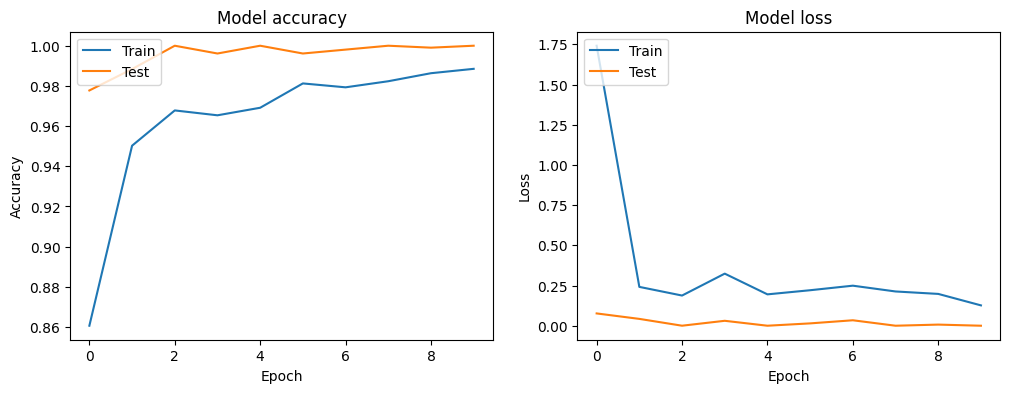

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


In [68]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

print(history.history.keys())
